<a href="https://colab.research.google.com/github/janithcyapa/SmartHVAC/blob/main/SmartHVAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library
https://scikit-fuzzy.github.io/scikit-fuzzy/

In [40]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 15.4 MB/s eta 0:00:00


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# - - - - I/O - - - -

> Antecedents (inputs)
- Temperature: very cool, cool, moderate, high, very high (16 - 30 C)
- Humidity : Low, Medium, High (0 - 100)

> Consequents (outputs)
- Compressor fan speed : 0 - 100 rpm
- Cooler voltage out : 0 - 5 V
- Heater voltage : 0 - 5 V

> Rules

- IF Temp (High) AND RH (High) : THEN Compressor Fan Speed is Very High (e.g., ~90 rpm)

- IF Temp (Medium) AND RH (Low) : THEN Compressor Fan Speed is Medium (e.g., ~50 rpm)

- IF Temp (Low) AND RH (Medium) : THEN Compressor Fan Speed is Low (e.g., ~30 rpm)

## Inputs & outputs & error

In [3]:
#inputs fuzzy logic variables
#convert np arrays to fuzzy variable using antecedent

temp_np = np.arange(0,51,1)
temp_sf = ctrl.Antecedent(temp_np,'temperature')

humid_np = np.arange(0,101,1)
humid_sf = ctrl.Antecedent(humid_np,'humidity')

t_error_np = np.arange(-5,6,1) #set point - actual temp
t_error_sf = ctrl.Antecedent(t_error_np, 'temp_error')

h_error_np = np.arange(-5,6,1) #set point - actual humid
h_error_sf = ctrl.Antecedent(h_error_np, 'humid_error')

print(temp_sf)
print(humid_sf)
print(t_error_sf)
print(h_error_sf)

#universe of each variable

print(temp_sf.universe)
print(humid_sf.universe)
print(t_error_sf.universe)
print(h_error_sf.universe)


Antecedent: temperature
Antecedent: humidity
Antecedent: temp_error
Antecedent: humid_error
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]
[-5 -4 -3 -2 -1  0  1  2  3  4  5]
[-5 -4 -3 -2 -1  0  1  2  3  4  5]


In [4]:
#output fuzzy logic variables need to control
#convert np arrays to fuzzy variable uisng Consequent

fspeed_np = np.arange(0, 1.01, 0.05)
fspeed_sf = ctrl.Consequent(fspeed_np, 'fan_speed')

cvolt_np = np.arange(0, 1.01, 0.05)
cvolt_sf = ctrl.Consequent(cvolt_np, 'cooler_volt')

hvolt_np = np.arange(0, 1.01, 0.05)
hvolt_sf = ctrl.Consequent(hvolt_np, 'heater_volt')

humidmoist_np = np.arange(0, 1.01, 0.05)
humidmoist_sf = ctrl.Consequent(humidmoist_np, 'moisture')

print(fspeed_sf)
print(cvolt_sf)
print(hvolt_sf)
print(humidmoist_sf)

print(fspeed_sf.universe)
print(cvolt_sf.universe)
print(hvolt_sf.universe)
print(humidmoist_sf.universe)

Consequent: fan_speed
Consequent: cooler_volt
Consequent: heater_volt
Consequent: moisture
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


##I - Temperature - Membership functions

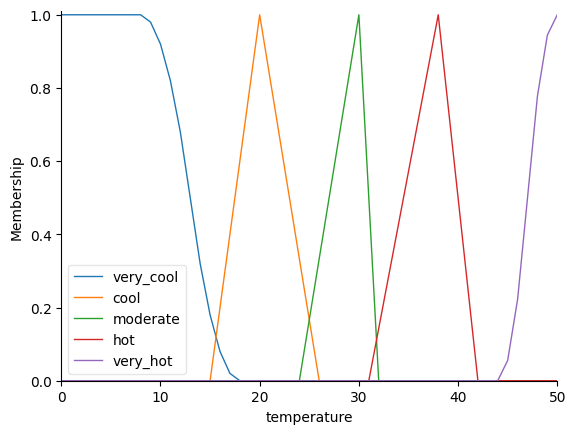

In [5]:
# Define membership functions for temperature
#zmf - z shaped mf, steep drop

#temp_universe = temp_sf.universe

very_cool_mf = fuzz.zmf(temp_np, 8, 18)
cool_mf = fuzz.trimf(temp_np, [15, 20, 26])
moderate_mf = fuzz.trimf(temp_np, [24, 30, 32])
hot_mf = fuzz.trimf(temp_np, [31, 38, 42])
very_hot_mf = fuzz.smf(temp_np, 44, 50)

# Assign temp mf to fuzzy input temperature variables
# link fuzzy lable very cool to it's mf very_cool_mf

temp_sf['very_cool'] = very_cool_mf
temp_sf['cool'] = cool_mf
temp_sf['moderate'] = moderate_mf
temp_sf['hot'] = hot_mf
temp_sf['very_hot'] = very_hot_mf

temp_sf.view()

In [6]:
# Setpoint temperature
temp_setp = 22

# Interpolate and find how much 22C belong to each memership function (0-1)
membership_values = {
    'very_cool': np.interp(temp_setp, temp_sf.universe, very_cool_mf),
    'cool': np.interp(temp_setp, temp_sf.universe, cool_mf),
    'moderate': np.interp(temp_setp, temp_sf.universe, moderate_mf),
    'hot': np.interp(temp_setp, temp_sf.universe, hot_mf),
    'very_hot': np.interp(temp_setp, temp_sf.universe, very_hot_mf),
}

# Print results

for label, value in membership_values.items():
    print(f"{label}: {value:.2f}")


very_cool: 0.00
cool: 0.67
moderate: 0.00
hot: 0.00
very_hot: 0.00


##I - Humidity - Membership Functions

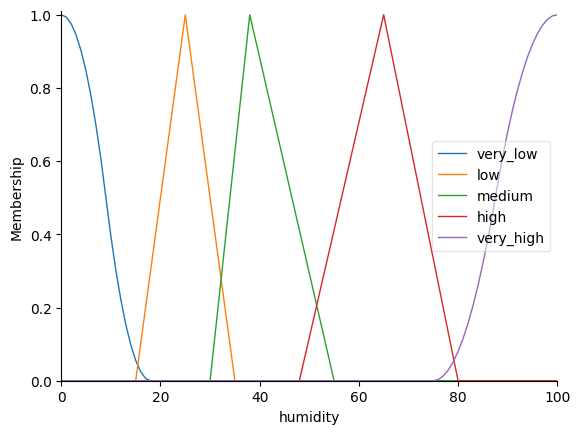

In [7]:
# Define membership functions for humidity
#zmf - z shaped mf, steep drop

#humidity_sf_universe = humidity_sf.universe

very_low_mf = fuzz.zmf(humid_np, 0, 18)
low_mf = fuzz.trimf(humid_np, [15, 25, 35])
medium_mf = fuzz.trimf(humid_np, [30, 38, 55])
high_mf = fuzz.trimf(humid_np, [48, 65, 80])
very_high_mf = fuzz.smf(humid_np, 75, 100)

# Assign humid mf to fuzzy input humidity variables
# link fuzzy lable very_high to it's mf very_high_mf

humid_sf['very_low'] = very_low_mf
humid_sf['low'] = low_mf
humid_sf['medium'] = medium_mf
humid_sf['high'] = high_mf
humid_sf['very_high'] = very_high_mf

humid_sf.view()

In [8]:
# Setpoint humidity
humid_setp = 53

# Interpolate and find how much 53% humidity belong to each memership function (0-1)
membership_values = {
    'very_high': np.interp(humid_setp, humid_sf.universe, very_high_mf),
    'high': np.interp(humid_setp, humid_sf.universe, high_mf),
    'medium': np.interp(humid_setp, humid_sf.universe, medium_mf),
    'low': np.interp(humid_setp, humid_sf.universe, low_mf),
    'very_low': np.interp(humid_setp, humid_sf.universe, very_low_mf),
}

# Print results

for label, value in membership_values.items():
    print(f"{label}: {value:.2f}")

very_high: 0.00
high: 0.29
medium: 0.12
low: 0.00
very_low: 0.00


##E - Temp error - Membership functions

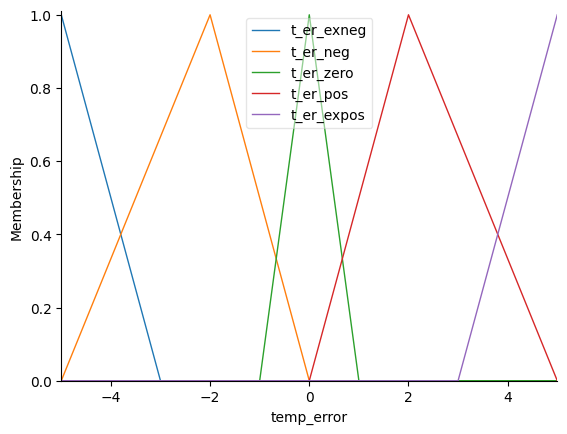

In [9]:
# Define membership functions for error = set point - current room temp
#zmf - z shaped mf, steep drop

#t_error_sf_universe = t_error_sf.universe

t_er_exneg_mf = fuzz.zmf(t_error_np, -5, -3)
t_er_neg_mf = fuzz.trimf(t_error_np, [-5, -2, 0]) #a,peak,b
t_er_zero_mf = fuzz.trimf(t_error_np, [-1, 0, 1])
t_er_pos_mf = fuzz.trimf(t_error_np, [0, 2, 5])
t_er_expos_mf = fuzz.smf(t_error_np, 3, 5)

# Assign t_error mf to fuzzy input t_error variables
# link fuzzy lable t_er_pos to it's mf t_er_pos_mf

t_error_sf['t_er_exneg'] = t_er_exneg_mf
t_error_sf['t_er_neg'] = t_er_neg_mf
t_error_sf['t_er_zero'] = t_er_zero_mf
t_error_sf['t_er_pos'] = t_er_pos_mf
t_error_sf['t_er_expos'] = t_er_expos_mf

t_error_sf.view()

In [10]:
#demo error

t_error_setp = -4

# Interpolate and find how much -4 t_error belong to each memership function (0-1)
membership_values = {
    't_er_exneg': np.interp(t_error_setp, t_error_sf.universe, t_er_exneg_mf),
    't_er_neg': np.interp(t_error_setp, t_error_sf.universe, t_er_neg_mf),
    't_er_zero': np.interp(t_error_setp, t_error_sf.universe, t_er_zero_mf),
    't_er_pos': np.interp(t_error_setp, t_error_sf.universe, t_er_pos_mf),
    't_er_expos': np.interp(t_error_setp, t_error_sf.universe, t_er_expos_mf),
}

# Print membership values
for label, value in membership_values.items():
    print(f"{label}: {value:.2f}")


t_er_exneg: 0.50
t_er_neg: 0.33
t_er_zero: 0.00
t_er_pos: 0.00
t_er_expos: 0.00


##E - Humidity error - Membership functions

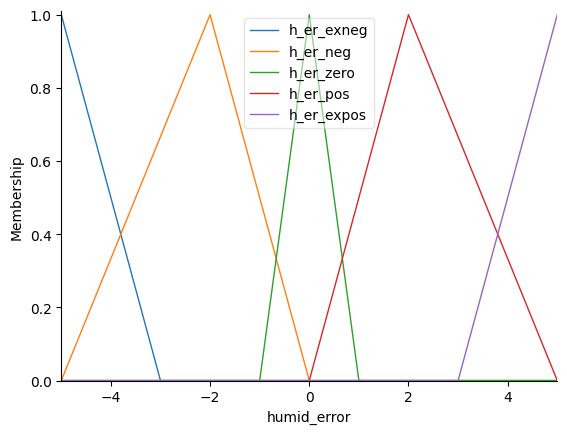

In [11]:
# Define membership functions for error = set point - current room temp
#zmf - z shaped mf, steep drop

#h_error_sf_universe = h_error_sf.universe

h_er_exneg_mf = fuzz.zmf(h_error_np, -5, -3)
h_er_neg_mf = fuzz.trimf(h_error_np, [-5, -2, 0]) #a,peak,b
h_er_zero_mf = fuzz.trimf(h_error_np, [-1, 0, 1])
h_er_pos_mf = fuzz.trimf(h_error_np, [0, 2, 5])
h_er_expos_mf = fuzz.smf(h_error_np, 3, 5)

# Assign h_error mf to fuzzy input h_error variables
# link fuzzy lable h_er_pos to it's mf h_er_pos_mf

h_error_sf['h_er_exneg'] = h_er_exneg_mf
h_error_sf['h_er_neg'] = h_er_neg_mf
h_error_sf['h_er_zero'] = h_er_zero_mf
h_error_sf['h_er_pos'] = h_er_pos_mf
h_error_sf['h_er_expos'] = h_er_expos_mf

h_error_sf.view()

In [12]:
#demo error

h_error_setp = 3.5

# Interpolate and find how much -4 t_error belong to each memership function (0-1)
membership_values = {
    'h_er_exneg': np.interp(h_error_setp, t_error_sf.universe, h_er_exneg_mf),
    'h_er_neg': np.interp(h_error_setp, t_error_sf.universe, h_er_neg_mf),
    'h_er_zero': np.interp(h_error_setp, t_error_sf.universe, h_er_zero_mf),
    'h_er_pos': np.interp(h_error_setp, t_error_sf.universe, h_er_pos_mf),
    'h_er_expos': np.interp(h_error_setp, t_error_sf.universe, h_er_expos_mf),
}

# Print membership values
for label, value in membership_values.items():
    print(f"{label}: {value:.2f}")


h_er_exneg: 0.00
h_er_neg: 0.00
h_er_zero: 0.00
h_er_pos: 0.50
h_er_expos: 0.25


##O - Fan speed - Membership functions

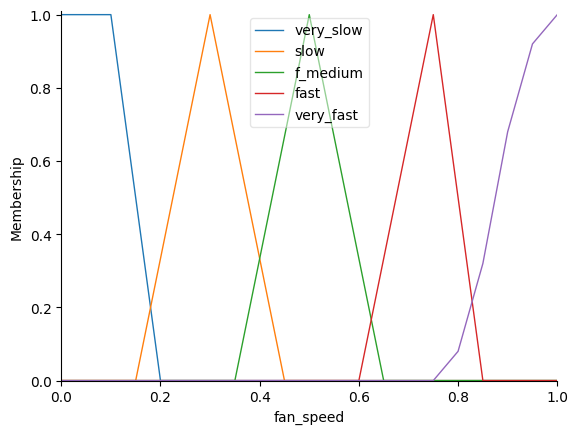

In [13]:
# Define membership functions for fan speed
#zmf - z shaped mf, steep drop

#fspeed_sf_universe = fspeed_sf.universe

very_slow_mf = fuzz.zmf(fspeed_np, 0.1, 0.2)
slow_mf = fuzz.trimf(fspeed_np, [0.15, 0.3, 0.45]) #a,peak,b
f_medium_mf = fuzz.trimf(fspeed_np, [0.35, 0.5, 0.65])
fast_mf = fuzz.trimf(fspeed_np, [0.6, 0.75, 0.85])
very_fast_mf = fuzz.smf(fspeed_np, 0.75, 1.0)

# Assign fspeed mf to fuzzy input fspeed variables
# link fuzzy lable very_slow to it's mf very_slow_mf

fspeed_sf['very_slow'] = very_slow_mf
fspeed_sf['slow'] = slow_mf
fspeed_sf['f_medium'] = f_medium_mf
fspeed_sf['fast'] = fast_mf
fspeed_sf['very_fast'] = very_fast_mf

fspeed_sf.view()

In [14]:
#demo fspeed

fspeed_setp = 0.41

# Interpolate and find how much -4 error belong to each memership function (0-1)
membership_values = {
    'very_fast': np.interp(fspeed_setp, fspeed_sf.universe, very_fast_mf),
    'fast': np.interp(fspeed_setp, fspeed_sf.universe, fast_mf),
    'f_medium': np.interp(fspeed_setp, fspeed_sf.universe, f_medium_mf),
    'slow': np.interp(fspeed_setp, fspeed_sf.universe, slow_mf),
    'very_slow': np.interp(fspeed_setp, fspeed_sf.universe, very_slow_mf),
}

# Print membership values
for label, value in membership_values.items():
    print(f"{label}: {value:.2f}")

very_fast: 0.00
fast: 0.00
f_medium: 0.40
slow: 0.27
very_slow: 0.00


##O - Cooler voltage speed - Membership functions

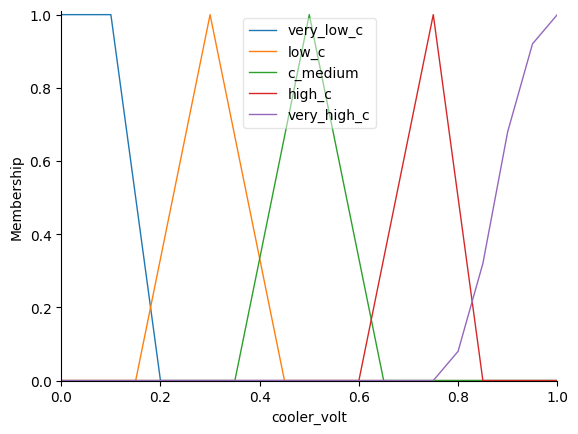

In [15]:
# Define membership functions for cooler voltage
#zmf - z shaped mf, steep drop

#cvolt_sf_universe = cvolt_sf.universe

very_low_c_mf = fuzz.zmf(cvolt_np, 0.1, 0.2)
low_c_mf = fuzz.trimf(cvolt_np, [0.15, 0.3, 0.45]) #a,peak,b
c_medium_mf = fuzz.trimf(cvolt_np, [0.35, 0.5, 0.65])
high_c_mf = fuzz.trimf(cvolt_np, [0.6, 0.75, 0.85])
very_high_c_mf = fuzz.smf(cvolt_np, 0.75, 1.0)

# Assign cvolt mf to fuzzy input cvolt variables
# link fuzzy lable very_low_c to it's mf very_low_c_mf

cvolt_sf['very_low_c'] = very_low_c_mf
cvolt_sf['low_c'] = low_c_mf
cvolt_sf['c_medium'] = c_medium_mf
cvolt_sf['high_c'] = high_c_mf
cvolt_sf['very_high_c'] = very_high_c_mf

cvolt_sf.view()

In [16]:
#demo cvolt

cvolt_setp = 0.34

# Interpolate and find how much -4 error belong to each memership function (0-1)
membership_values = {
    'very_high_c': np.interp(cvolt_setp, cvolt_sf.universe, very_high_c_mf),
    'high_c': np.interp(cvolt_setp, cvolt_sf.universe, high_c_mf),
    'c_medium': np.interp(cvolt_setp, cvolt_sf.universe, c_medium_mf),
    'low_c': np.interp(cvolt_setp, cvolt_sf.universe, low_c_mf),
    'very_low_c': np.interp(cvolt_setp, cvolt_sf.universe, very_low_c_mf),
}

# Print membership values
for label, value in membership_values.items():
    print(f"{label}: {value:.2f}")

very_high_c: 0.00
high_c: 0.00
c_medium: 0.00
low_c: 0.73
very_low_c: 0.00


##O - Heater voltage speed - Membership functions

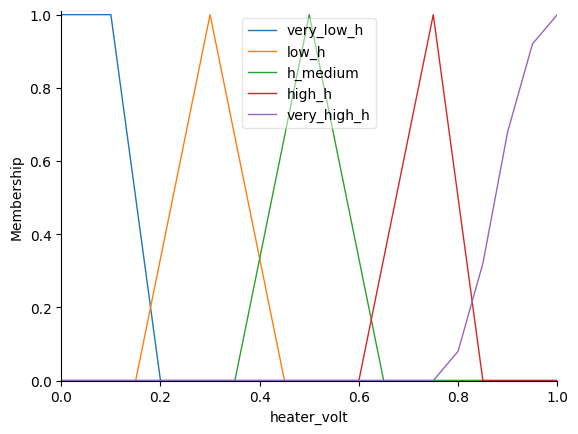

In [17]:
# Define membership functions for cooler voltage
#zmf - z shaped mf, steep drop

#hvolt_sf_universe = hvolt_sf.universe

very_low_h_mf = fuzz.zmf(hvolt_np, 0.1, 0.2)
low_h_mf = fuzz.trimf(hvolt_np, [0.15, 0.3, 0.45]) #a,peak,b
h_medium_mf = fuzz.trimf(hvolt_np, [0.35, 0.5, 0.65])
high_h_mf = fuzz.trimf(hvolt_np, [0.6, 0.75, 0.85])
very_high_h_mf = fuzz.smf(hvolt_np, 0.75, 1.0)

# Assign hvolt mf to fuzzy input hvolt variables
# link fuzzy lable very_low_h to it's mf very_low_h_mf

hvolt_sf['very_low_h'] = very_low_h_mf
hvolt_sf['low_h'] = low_h_mf
hvolt_sf['h_medium'] = h_medium_mf
hvolt_sf['high_h'] = high_h_mf
hvolt_sf['very_high_h'] = very_high_h_mf

hvolt_sf.view()

In [18]:
#demo hvolt

hvolt_setp = 0.79

# Interpolate and find how much -4 error belong to each memership function (0-1)
membership_values = {
    'very_high_h': np.interp(hvolt_setp, hvolt_sf.universe, very_high_h_mf),
    'high_h': np.interp(hvolt_setp, hvolt_sf.universe, high_h_mf),
    'h_medium': np.interp(hvolt_setp, hvolt_sf.universe, h_medium_mf),
    'low_h': np.interp(hvolt_setp, hvolt_sf.universe, low_h_mf),
    'very_low_h': np.interp(hvolt_setp, hvolt_sf.universe, very_low_h_mf),
}

# Print membership values
for label, value in membership_values.items():
    print(f"{label}: {value:.2f}")

very_high_h: 0.06
high_h: 0.60
h_medium: 0.00
low_h: 0.00
very_low_h: 0.00


##O - Humidifier flow content - Membership functions

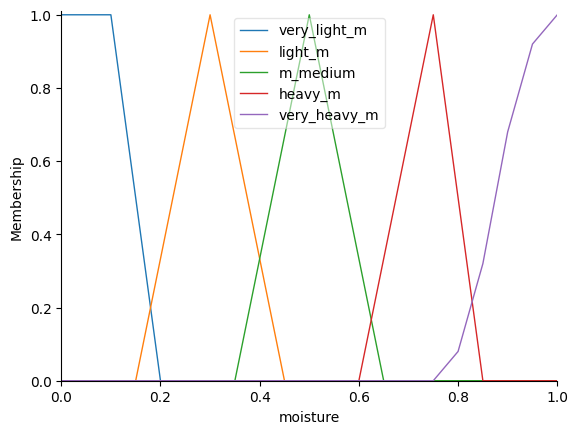

In [19]:
# Define membership functions for humididfier voltage
#zmf - z shaped mf, steep drop

#humidmoist_sf_universe = humidmoist_sf.universe

#mist

very_light_m_mf = fuzz.zmf(humidmoist_np, 0.1, 0.2)
light_m_mf = fuzz.trimf(humidmoist_np, [0.15, 0.3, 0.45]) #a,peak,b
m_medium_mf = fuzz.trimf(humidmoist_np, [0.35, 0.5, 0.65])
heavy_m_mf = fuzz.trimf(humidmoist_np, [0.6, 0.75, 0.85])
very_heavy_m_mf = fuzz.smf(humidmoist_np, 0.75, 1.0)

# Assign humidmoist mf to fuzzy input humidmoist variables
# link fuzzy lable very_light_m to it's mf very_light_m_mf

humidmoist_sf['very_light_m'] = very_light_m_mf
humidmoist_sf['light_m'] = light_m_mf
humidmoist_sf['m_medium'] = m_medium_mf
humidmoist_sf['heavy_m'] = heavy_m_mf
humidmoist_sf['very_heavy_m'] = very_heavy_m_mf

humidmoist_sf.view()

In [20]:
#demo humidmoist

humidmoist_setp = 0.57

# Interpolate and find how much -4 error belong to each memership function (0-1)
membership_values = {
    'very_heavy_m': np.interp(humidmoist_setp, humidmoist_sf.universe, very_heavy_m_mf),
    'heavy_m': np.interp(humidmoist_setp, humidmoist_sf.universe, heavy_m_mf),
    'm_medium': np.interp(humidmoist_setp, humidmoist_sf.universe, h_medium_mf),
    'light_m': np.interp(humidmoist_setp, humidmoist_sf.universe, light_m_mf),
    'very_light_m': np.interp(humidmoist_setp, humidmoist_sf.universe, very_light_m_mf),
}

# Print membership values
for label, value in membership_values.items():
    print(f"{label}: {value:.2f}")

very_heavy_m: 0.00
heavy_m: 0.00
m_medium: 0.53
light_m: 0.00
very_light_m: 0.00


# - - - - Simple Fuzzy - - - -

##Rules by me

In [21]:
#rules for fuzzy logic


# Rule 1
rule1a = ctrl.Rule(t_error_sf['t_er_exneg'] | h_error_sf['h_er_exneg'], fspeed_sf['very_fast'])
rule1b = ctrl.Rule(t_error_sf['t_er_exneg'] | h_error_sf['h_er_exneg'], cvolt_sf['very_high_c'])
rule1c = ctrl.Rule(t_error_sf['t_er_exneg'] | h_error_sf['h_er_exneg'], hvolt_sf['very_high_h'])

# Rule 2
rule2a = ctrl.Rule(t_error_sf['t_er_neg'] | h_error_sf['h_er_neg'], fspeed_sf['fast'])
rule2b = ctrl.Rule(t_error_sf['t_er_neg'] | h_error_sf['h_er_neg'], cvolt_sf['high_c'])
rule2c = ctrl.Rule(t_error_sf['t_er_neg'] | h_error_sf['h_er_neg'], hvolt_sf['high_h'])

# Rule 3
rule3a = ctrl.Rule(t_error_sf['t_er_zero'] | h_error_sf['h_er_zero'], fspeed_sf['f_medium'])
rule3b = ctrl.Rule(t_error_sf['t_er_zero'] | h_error_sf['h_er_zero'], cvolt_sf['c_medium'])
rule3c = ctrl.Rule(t_error_sf['t_er_zero'] | h_error_sf['h_er_zero'], hvolt_sf['h_medium'])

# Rule 4
rule4a = ctrl.Rule(t_error_sf['t_er_pos'] | h_error_sf['h_er_pos'], fspeed_sf['slow'])
rule4b = ctrl.Rule(t_error_sf['t_er_pos'] | h_error_sf['h_er_pos'], cvolt_sf['low_c'])
rule4c = ctrl.Rule(t_error_sf['t_er_pos'] | h_error_sf['h_er_pos'], hvolt_sf['low_h'])

# Rule 5
rule5a = ctrl.Rule(t_error_sf['t_er_expos'] | h_error_sf['h_er_expos'], fspeed_sf['very_slow'])
rule5b = ctrl.Rule(t_error_sf['t_er_expos'] | h_error_sf['h_er_expos'], cvolt_sf['very_low_c'])
rule5c = ctrl.Rule(t_error_sf['t_er_expos'] | h_error_sf['h_er_expos'], hvolt_sf['very_low_h'])


In [22]:
#build control system
control_system = ctrl.ControlSystem([
    rule1a, rule1b, rule1c,
    rule2a, rule2b, rule2c,
    rule3a, rule3b, rule3c,
    rule4a, rule4b, rule4c,
    rule5a, rule5b, rule5c
])


In [23]:
#build fuzzy system

fuzzy_system = ctrl.ControlSystemSimulation(control_system)
fuzzy_system


In [24]:
#testing demo values

fuzzy_system.input['temp_error'] = 5
fuzzy_system.input['humid_error'] = -2

fuzzy_system.compute()

print("Fan Speed:", fuzzy_system.output['fan_speed'])
print("Compressor Voltage:", fuzzy_system.output['cooler_volt'])
print("Heater Voltage:", fuzzy_system.output['heater_volt'])

'''fspeed_sf.view(sim = fuzzy_system)
cvolt_sf.view(sim = fuzzy_system)
hvolt_sf.view(sim = fuzzy_system)'''


Fan Speed: 0.3757575757575758
Compressor Voltage: 0.3757575757575758
Heater Voltage: 0.3757575757575758


'fspeed_sf.view(sim = fuzzy_system)\ncvolt_sf.view(sim = fuzzy_system)\nhvolt_sf.view(sim = fuzzy_system)'

##Rules by Grok

In [25]:
# Assuming all antecedents and consequents are defined as in your code
# (temp_error_sf, h_error_sf, fspeed_sf, cvolt_sf, hvolt_sf, humidmoist_sf)

# Define thermodynamically correct rules
rules = [
    # Temperature too hot (t_er_exneg, t_er_neg)
    ctrl.Rule(t_error_sf['t_er_exneg'] & h_error_sf['h_er_zero'],
              [fspeed_sf['very_fast'], cvolt_sf['very_high_c'], hvolt_sf['very_low_h'], humidmoist_sf['very_light_m']]),
    ctrl.Rule(t_error_sf['t_er_neg'] & h_error_sf['h_er_zero'],
              [fspeed_sf['fast'], cvolt_sf['high_c'], hvolt_sf['very_low_h'], humidmoist_sf['very_light_m']]),

    # Temperature too cold (t_er_expos, t_er_pos)
    ctrl.Rule(t_error_sf['t_er_expos'] & h_error_sf['h_er_zero'],
              [fspeed_sf['very_fast'], cvolt_sf['very_low_c'], hvolt_sf['very_high_h'], humidmoist_sf['very_light_m']]),
    ctrl.Rule(t_error_sf['t_er_pos'] & h_error_sf['h_er_zero'],
              [fspeed_sf['fast'], cvolt_sf['very_low_c'], hvolt_sf['high_h'], humidmoist_sf['very_light_m']]),

    # Temperature and humidity at set point (minimize power)
    ctrl.Rule(t_error_sf['t_er_zero'] & h_error_sf['h_er_zero'],
              [fspeed_sf['very_slow'], cvolt_sf['very_low_c'], hvolt_sf['very_low_h'], humidmoist_sf['very_light_m']]),

    # Humidity too high (h_er_exneg, h_er_neg)
    ctrl.Rule(t_error_sf['t_er_zero'] & h_error_sf['h_er_exneg'],
              [fspeed_sf['fast'], cvolt_sf['very_high_c'], hvolt_sf['very_low_h'], humidmoist_sf['very_light_m']]),
    ctrl.Rule(t_error_sf['t_er_zero'] & h_error_sf['h_er_neg'],
              [fspeed_sf['f_medium'], cvolt_sf['high_c'], hvolt_sf['very_low_h'], humidmoist_sf['very_light_m']]),

    # Humidity too low (h_er_expos, h_er_pos)
    ctrl.Rule(t_error_sf['t_er_zero'] & h_error_sf['h_er_expos'],
              [fspeed_sf['f_medium'], cvolt_sf['very_low_c'], hvolt_sf['very_low_h'], humidmoist_sf['very_heavy_m']]),
    ctrl.Rule(t_error_sf['t_er_zero'] & h_error_sf['h_er_pos'],
              [fspeed_sf['slow'], cvolt_sf['very_low_c'], hvolt_sf['very_low_h'], humidmoist_sf['heavy_m']]),

    # Combined cases
    ctrl.Rule(t_error_sf['t_er_expos'] & h_error_sf['h_er_neg'],
              [fspeed_sf['fast'], cvolt_sf['low_c'], hvolt_sf['very_high_h'], humidmoist_sf['very_light_m']]),
    ctrl.Rule(t_error_sf['t_er_exneg'] & h_error_sf['h_er_exneg'],
              [fspeed_sf['very_fast'], cvolt_sf['very_high_c'], hvolt_sf['very_low_h'], humidmoist_sf['very_light_m']]),
    ctrl.Rule(t_error_sf['t_er_expos'] & h_error_sf['h_er_expos'],
              [fspeed_sf['very_fast'], cvolt_sf['very_low_c'], hvolt_sf['very_high_h'], humidmoist_sf['very_heavy_m']]),
    ctrl.Rule(t_error_sf['t_er_neg'] & h_error_sf['h_er_neg'],
              [fspeed_sf['fast'], cvolt_sf['high_c'], hvolt_sf['very_low_h'], humidmoist_sf['very_light_m']]),
    ctrl.Rule(t_error_sf['t_er_pos'] & h_error_sf['h_er_pos'],
              [fspeed_sf['fast'], cvolt_sf['very_low_c'], hvolt_sf['high_h'], humidmoist_sf['heavy_m']]),
]

# Create control system
control_system = ctrl.ControlSystem(rules)
fuzzy_system = ctrl.ControlSystemSimulation(control_system)

In [26]:
# Set inputs
fuzzy_system.input['temp_error'] = 5
fuzzy_system.input['humid_error'] = -2

# Compute
fuzzy_system.compute()

# Print outputs
print("Fan Speed:", fuzzy_system.output['fan_speed'])
print("Cooler Voltage:", fuzzy_system.output['cooler_volt'])
print("Heater Voltage:", fuzzy_system.output['heater_volt'])
print("Moisture:", fuzzy_system.output['moisture'])

# Visualize outputs
'''fspeed_sf.view(sim=fuzzy_system)
cvolt_sf.view(sim=fuzzy_system)
hvolt_sf.view(sim=fuzzy_system)
humidmoist_sf.view(sim=fuzzy_system)'''

Fan Speed: 0.7333333333333333
Cooler Voltage: 0.3
Heater Voltage: 0.9254666666666667
Moisture: 0.07777777777777779


'fspeed_sf.view(sim=fuzzy_system)\ncvolt_sf.view(sim=fuzzy_system)\nhvolt_sf.view(sim=fuzzy_system)\nhumidmoist_sf.view(sim=fuzzy_system)'

#- - - - Connect LlaMA - - - -

In [ ]:
!pip install transformers accelerate bitsandbytes


In [ ]:
!pip install -U bitsandbytes accelerate transformers


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define quantization config for 8-bit loading
quant_config = BitsAndBytesConfig(load_in_8bit=True)


from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")



In [ ]:
prompt = "Generate fuzzy logic rules for HVAC system where temperature and humidity inputs control fan speed and voltage outputs."

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

outputs = model.generate(**inputs, max_new_tokens=150)

print(tokenizer.decode(outputs[0], skip_special_tokens=True))


In [ ]:
from transformers import pipeline

model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
generator = pipeline("text-generation", model=model_name, device=0)

prompt = """
You are an expert in control systems. Generate fuzzy logic control rules.

Inputs:
- Temperature: very cool, cool, moderate, high, very high
- Humidity: low, medium, high

Outputs:
- Fan Speed: low, medium, high
- Compressor Voltage: low, medium, high
- Heater Voltage: low, medium, high

Generate 5 rules, Rules must follow this format excatly, only channge the [level] appropriately:
IF temperature is [level] AND/OR humidity is [level] THEN fan_speed is [level], compressor_voltage is [level], heater_voltage is [level]
"""

response = generator(prompt, max_new_tokens=300, do_sample=True, temperature=0.7)[0]['generated_text']
print(response)

rules = response.split('\n')
for rule in rules:
    if "IF" in rule and "THEN" in rule:
        print(rule.strip())


In [ ]:
rules_text = [
    "IF temperature is very cool AND humidity is high THEN fan_speed is low, compressor_voltage is medium, heater_voltage is high",
    "IF temperature is cool OR humidity is medium THEN fan_speed is medium, compressor_voltage is low, heater_voltage is medium",
    "IF temperature is moderate AND humidity is low THEN fan_speed is medium, compressor_voltage is low, heater_voltage is low",
    "IF temperature is high OR humidity is high THEN fan_speed is high, compressor_voltage is high, heater_voltage is low",
    "IF temperature is very high AND humidity is medium THEN fan_speed is high, compressor_voltage is high, heater_voltage is medium",
]


In [ ]:
import numpy as np
import skfuzzy as fuzz
import skfuzzy.control as ctrl

In [ ]:
#inputs

temp = ctrl.Antecedent(np.arange(16,31,1),'temperature')
humidity = ctrl.Antecedent(np.arange(0,101,1),'humidity')
print(temp)
print(humidity)
print(temp.universe)
print(humidity.universe)

In [ ]:
#output

f_speed = ctrl.Consequent(np.arange(0,101,1),'f_speed')
c_volt = ctrl.Consequent(np.arange(0,6,1),'c_volt')
h_volt = ctrl.Consequent(np.arange(0,6,1),'h_volt')
print(f_speed)
print(c_volt)
print(h_volt)
print(f_speed.universe)
print(c_volt.universe)
print(h_volt.universe)

In [ ]:
#membership fn for inputs

temp.automf(number=5,names=['very cool', 'cool', 'moderate', 'high', 'very high'])
humidity.automf(number=3,names=['low', 'medium', 'high'])

temp.view()
humidity.view()

In [ ]:
#custom output membership fns for f_speed

f_speed['low']= fuzz.trimf(f_speed.universe,[0,0,50])
f_speed['medium']= fuzz.trimf(f_speed.universe,[0,50,100])
f_speed['high']= fuzz.trimf(f_speed.universe,[50,100,100])

f_speed.view()

#custom output membership fns for c_volt

c_volt['low']= fuzz.trimf(c_volt.universe,[0,0,30])
c_volt['medium']= fuzz.trimf(c_volt.universe,[0,30,50])
c_volt['high']= fuzz.trimf(c_volt.universe,[30,50,50])

c_volt.view()

#custom output membership fns for h_volt

h_volt['low']= fuzz.trimf(h_volt.universe,[0,0,30])
h_volt['medium']= fuzz.trimf(h_volt.universe,[0,30,50])
h_volt['high']= fuzz.trimf(h_volt.universe,[30,50,50])

h_volt.view()


In [ ]:
print("Temperature labels:", list(temp.terms.keys()))


In [ ]:
import skfuzzy.control as ctrl

# Define fuzzy variables (assuming you’ve done this earlier in your code)
temperature = ctrl.Antecedent(np.arange(0, 51, 1), 'temperature')
humidity = ctrl.Antecedent(np.arange(0, 101, 1), 'humidity')
f_speed = ctrl.Consequent(np.arange(0, 101, 1), 'f_speed')
c_volt = ctrl.Consequent(np.arange(0, 101, 1), 'c_volt')
h_volt = ctrl.Consequent(np.arange(0, 101, 1), 'h_volt')

# Replace this with your actual fuzzy sets for temp/humidity/outputs
# temperature['very cool'], humidity['low'], etc.

# Parsing function
def parse_rule(text, index):
    logic = '&' if "AND" in text else '|'

    # Extract values
    parts = text.replace("IF ", "").replace(" THEN ", ";").split(";")
    condition, actions = parts[0], parts[1]

    conds = condition.strip().split(f" {'AND' if logic == '&' else 'OR'} ")
    cond1_key, cond1_val = conds[0].split(" is ")
    cond2_key, cond2_val = conds[1].split(" is ")

    fan_speed = actions.split(",")[0].split(" is ")[1].strip()
    comp_voltage = actions.split(",")[1].split(" is ")[1].strip()
    heater_voltage = actions.split(",")[2].split(" is ")[1].strip()

    rule_fs = ctrl.Rule(eval(f"{cond1_key.strip()}['{cond1_val.strip()}'] {logic} {cond2_key.strip()}['{cond2_val.strip()}']"), f_speed[fan_speed])
    rule_cv = ctrl.Rule(eval(f"{cond1_key.strip()}['{cond1_val.strip()}'] {logic} {cond2_key.strip()}['{cond2_val.strip()}']"), c_volt[comp_voltage])
    rule_hv = ctrl.Rule(eval(f"{cond1_key.strip()}['{cond1_val.strip()}'] {logic} {cond2_key.strip()}['{cond2_val.strip()}']"), h_volt[heater_voltage])

    return rule_fs, rule_cv, rule_hv

# Build all rules
all_rules = []
for i, r in enumerate(rules_text):
    fs, cv, hv = parse_rule(r, i)
    all_rules.extend([fs, cv, hv])

# Create control system
control_system = ctrl.ControlSystem(all_rules)
fuzzy_system = ctrl.ControlSystemSimulation(control_system)


#- - - -Connect OpenAI API- - - -

##Runs

In [27]:
#install openai library

!pip install --upgrade openai

from openai import OpenAI
from getpass import getpass

#secure API key enter
api_key = getpass("Enter your OpenAI API key: ")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 765.0/765.0 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.96.1
    Uninstalling openai-1.96.1:
      Successfully uninstalled openai-1.96.1
Enter your OpenAI API key: ··········


In [29]:
# Initialize client
client = OpenAI(api_key=api_key)

In [30]:
#prompt

prompt = """
You are an expert in control systems. Generate 5 fuzzy logic control rules.

Inputs:
- Temperature: very cool, cool, moderate, high, very high
- Humidity: low, medium, high

Outputs:
- Fan Speed: low, medium, high
- Compressor Voltage: low, medium, high
- Heater Voltage: low, medium, high

Rules must follow **this exact format**:
IF temperature is [level] AND/OR humidity is [level] THEN fan_speed is [level], compressor_voltage is [level], heater_voltage is [level]

Use only values from the lists. Do not add any extra text.
use AND or OR as you wish
"""


In [ ]:
def get_temp_level(temp_c):
    if temp_c <= 10:
        return "very cool"
    elif 11 <= temp_c <= 15:
        return "cool"
    elif 16 <= temp_c <= 25:
        return "moderate"
    elif 26 <= temp_c <= 30:
        return "high"
    else:
        return "very high"

def get_humidity_level(rh_percent):
    if rh_percent <= 30:
        return "low"
    elif 31 <= rh_percent <= 60:
        return "medium"
    else:
        return "high"

# Example sensor input values:
temperature_input = 22
humidity_input = 45

temp_level = get_temp_level(temperature_input)
humidity_level = get_humidity_level(humidity_input)

# Now create your prompt using these levels
prompt1 = f"""
You are an expert in control systems. Generate 5 fuzzy logic control rule.

Inputs:
- Temperature: very cool, cool, moderate, high, very high
- Humidity: low, medium, high

Outputs:
- Fan Speed: low, medium, high
- Compressor Voltage: low, medium, high
- Heater Voltage: low, medium, high

Rules must follow **this exact format**:
IF temperature is {temp_level} AND/OR humidity is {humidity_level} THEN fan_speed is [level], compressor_voltage is [level], heater_voltage is [level]

Use only values from the lists. Do not add any extra text.
"""

#rint(prompt)


In [ ]:
# Get response from gpt

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": prompt1}
    ],
    temperature=0.5,
)

# Extract content from response
rules_text = response.choices[0].message.content
print(rules_text)


1. IF temperature is very cool AND humidity is low THEN fan_speed is low, compressor_voltage is low, heater_voltage is high  
2. IF temperature is high AND humidity is medium THEN fan_speed is medium, compressor_voltage is high, heater_voltage is low  
3. IF temperature is moderate AND humidity is high THEN fan_speed is high, compressor_voltage is medium, heater_voltage is low  
4. IF temperature is cool AND humidity is low THEN fan_speed is low, compressor_voltage is medium, heater_voltage is medium  
5. IF temperature is very high AND humidity is high THEN fan_speed is high, compressor_voltage is high, heater_voltage is low  


In [ ]:
def parse_fuzzy_rule(text, rule_index=1):
    """
    Convert LLM output fuzzy rule into skfuzzy.ctrl.Rule format.
    Returns a list of rule strings.
    """
    import re

    # Clean and split rule
    rule_line = text.strip().replace("IF ", "")
    condition_part, output_part = rule_line.split(" THEN ")

    # Detect logical operator
    if " AND " in condition_part:
        conds = condition_part.split(" AND ")
        join_op = " & "
    elif " OR " in condition_part:
        conds = condition_part.split(" OR ")
        join_op = " | "
    else:
        conds = [condition_part]
        join_op = ""

    # Process conditions
    cond_exprs = []
    for cond in conds:
        var, level = cond.strip().split(" is ")
        var_map = {
            "temperature": "temp",
            "humidity": "humidity"
        }
        cond_exprs.append(f"{var_map[var.strip()]}['{level.strip()}']")

    # Join conditions
    full_condition = join_op.join(cond_exprs)

    # Process outputs
    outputs = output_part.split(",")
    output_map = {
        "fan_speed": "f_speed",
        "compressor_voltage": "c_volt",
        "heater_voltage": "h_volt"
    }

    rules = []
    for i, out in enumerate(outputs):
        var, level = out.strip().split(" is ")
        var = var.strip()
        level = level.strip()
        rule_str = f"rule{rule_index}{chr(97 + i)} = ctrl.Rule({full_condition}, {output_map[var]}['{level}'])"
        rules.append(rule_str)

    return rules


In [ ]:
import re

# Clean and extract only lines that contain actual rules
llm_rules = [re.sub(r"^\d+\.\s*", "", line.strip()) for line in rules_text.split("\n") if "IF" in line and "THEN" in line]


final_rules = []
for i, rule in enumerate(llm_rules):
    fuzzy_rules = parse_fuzzy_rule(rule, i + 1)
    final_rules.extend(fuzzy_rules)

# Print the final rules in scikit-fuzzy format

for i, r in enumerate(final_rules, 1):
    print(r)
    if i % 3 == 0:
        print()  # Add blank line after every 3 rules (i.e., after 1a,1b,1c)


rule1a = ctrl.Rule(temp['very high'] & humidity['high'], f_speed['high'])
rule1b = ctrl.Rule(temp['very high'] & humidity['high'], c_volt['high'])
rule1c = ctrl.Rule(temp['very high'] & humidity['high'], h_volt['low'])

rule2a = ctrl.Rule(temp['moderate'] & humidity['medium'], f_speed['medium'])
rule2b = ctrl.Rule(temp['moderate'] & humidity['medium'], c_volt['medium'])
rule2c = ctrl.Rule(temp['moderate'] & humidity['medium'], h_volt['low'])

rule3a = ctrl.Rule(temp['cool'] | humidity['low'], f_speed['low'])
rule3b = ctrl.Rule(temp['cool'] | humidity['low'], c_volt['low'])
rule3c = ctrl.Rule(temp['cool'] | humidity['low'], h_volt['medium'])

rule4a = ctrl.Rule(temp['high'] & humidity['low'], f_speed['medium'])
rule4b = ctrl.Rule(temp['high'] & humidity['low'], c_volt['medium'])
rule4c = ctrl.Rule(temp['high'] & humidity['low'], h_volt['low'])

rule5a = ctrl.Rule(temp['very cool'] & humidity['high'], f_speed['low'])
rule5b = ctrl.Rule(temp['very cool'] & humidity['high'], c_volt['low'])

In [ ]:
#build control system
control_system = ctrl.ControlSystem([
    rule1a, rule1b, rule1c,
    rule2a, rule2b, rule2c,
    rule3a, rule3b, rule3c,
    rule4a, rule4b, rule4c,
    rule5a, rule5b, rule5c
])


In [ ]:
#build fuzzy system

fuzzy_system = ctrl.ControlSystemSimulation(control_system)
fuzzy_system


In [ ]:
#testing demo values

fuzzy_system.input['temperature'] = 25
fuzzy_system.input['humidity'] = 50

fuzzy_system.compute()

print("Fan Speed:", round((fuzzy_system.output['f_speed']),4))
print("Compressor Voltage:", round((fuzzy_system.output['c_volt']),4))
print("Heater Voltage:", round((fuzzy_system.output['h_volt']),4))

#f_speed.view(sim = fuzzy_system)
#c_volt.view(sim = fuzzy_system)
#h_volt.view(sim = fuzzy_system)


Fan Speed: 46.3941
Compressor Voltage: 2.4364
Heater Voltage: 2.4364


##New Prompt July 19tth

In [31]:
# Define the prompt
prompt = """
Generate a set of fuzzy logic rules for an HVAC system to control temperature and humidity, optimizing for minimal power consumption while maintaining comfort (reaching set points). The system has two inputs:
- Temperature error (t_error_sf): linguistic terms are t_er_exneg, t_er_neg, t_er_zero, t_er_pos, t_er_expos.
- Humidity error (h_error_sf): linguistic terms are h_er_exneg, h_er_neg, h_er_zero, h_er_pos, h_er_expos.
The system has four outputs:
- Fan speed (fspeed_sf): very_slow, slow, f_medium, fast, very_fast.
- Cooler voltage (cvolt_sf): very_low_c, low_c, c_medium, high_c, very_high_c.
- Heater voltage (hvolt_sf): very_low_h, low_h, h_medium, high_h, very_high_h.
- Humidifier moisture (humidmost_sf): very_light_m, light_m, m_medium, heavy_m, very_heavy_m.
Rules should be thermodynamically correct:
- If t_error_sf is positive (t_er_pos, t_er_expos), increase hvolt_sf, minimize cvolt_sf, use moderate to high fspeed_sf.
- If t_error_sf is negative (t_er_neg, t_er_exneg), increase cvolt_sf, minimize hvolt_sf, use moderate to high fspeed_sf.
- If t_error_sf is t_er_zero, minimize both hvolt_sf and cvolt_sf, use very_slow fspeed_sf.
- If h_error_sf is positive (h_er_pos, h_er_expos), increase humidmost_sf.
- If h_error_sf is negative (h_er_neg, h_er_exneg), minimize humidmost_sf, increase cvolt_sf for dehumidification if temperature allows.
- Avoid simultaneous high hvolt_sf and cvolt_sf to save energy.
Generate at least 12 rules covering key combinations, including t_error_af = t_er_expos and h_error_sf = h_er_neg. Output each rule must follow **this exact format**:
IF t_error_sf is [level] AND/OR h_error_sf_sf is [level] THEN fspeed_sf is [level], cvolt_sf is [level], hvolt_sf is [level], humidmost_sf is [level]
Ensure rules are concise and use AND or OR for combining inputs.
"""



In [32]:
# Get response from gpt

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": prompt
    ],
    temperature=0.3,
)

# Extract content from response
rules_text = response.choices[0].message.content
print(rules_text)

Here is a set of fuzzy logic rules for the HVAC system that optimizes for minimal power consumption while maintaining comfort:

1. IF t_error_sf is t_er_expos AND h_error_sf is h_er_neg THEN fspeed_sf is fast, cvolt_sf is high_c, hvolt_sf is very_low_h, humidmost_sf is very_light_m
2. IF t_error_sf is t_er_pos AND h_error_sf is h_er_zero THEN fspeed_sf is moderate, cvolt_sf is very_low_c, hvolt_sf is high_h, humidmost_sf is very_light_m
3. IF t_error_sf is t_er_pos AND h_error_sf is h_er_pos THEN fspeed_sf is fast, cvolt_sf is very_low_c, hvolt_sf is high_h, humidmost_sf is heavy_m
4. IF t_error_sf is t_er_neg AND h_error_sf is h_er_exneg THEN fspeed_sf is moderate, cvolt_sf is high_c, hvolt_sf is very_low_h, humidmost_sf is very_light_m
5. IF t_error_sf is t_er_neg AND h_error_sf is h_er_zero THEN fspeed_sf is moderate, cvolt_sf is high_c, hvolt_sf is very_low_h, humidmost_sf is very_light_m
6. IF t_error_sf is t_er_zero AND h_error_sf is h_er_pos THEN fspeed_sf is very_slow, cvolt_sf

In [33]:
# Parse rules into scikit-fuzzy ctrl.Rule objects
rules = []
for rule in rules_text.strip().split('\n'):
    if rule.startswith("IF") or rule.startswith("1. IF"):  # Handle numbered rules
        # Remove numbering if present (e.g., "1. IF" -> "IF")
        rule = rule.split("IF", 1)[1] if rule.startswith("1.") else rule
        # Split into condition and outputs: "IF ... THEN ..."
        parts = rule.replace("IF ", "").replace(" THEN ", "|").split("|")
        condition, outputs = parts[0], parts[1]
        # Parse condition: "t_error_sf is t_er_expos AND h_error_sf is h_er_neg"
        cond_parts = condition.split(" AND ")
        temp_cond = cond_parts[0].split(" is ")[1].strip()
        humid_cond = cond_parts[1].split(" is ")[1].strip()
        # Parse outputs: "fspeed_sf is fast, cvolt_sf is high_c, hvolt_sf is very_low_h, humidmost_sf is very_light_m"
        output_parts = outputs.split(", ")
        fan_out = output_parts[0].split(" is ")[1].strip()
        cooler_out = output_parts[1].split(" is ")[1].strip()
        heater_out = output_parts[2].split(" is ")[1].strip()
        humid_out = output_parts[3].split(" is ")[1].strip()
        # Fix typo in humidifier output (humidmost_sf -> humidmoist_sf)
        humid_out = humid_out.replace("humidmost_sf", "humidmoist_sf")
        # Map 'moderate' to 'f_medium' for fspeed_sf
        fan_out = "f_medium" if fan_out == "moderate" else fan_out
        # Create rule in desired format
        rule_str = (f"ctrl.Rule(t_error_sf['{temp_cond}'] & h_error_sf['{humid_cond}'], "
                    f"[fspeed_sf['{fan_out}'], cvolt_sf['{cooler_out}'], hvolt_sf['{heater_out}'], humidmoist_sf['{humid_out}']])")
        rules.append(rule_str)

# Print rules in the requested format
for rule_str in rules:
    print(rule_str)

# Create actual ctrl.Rule objects (assuming antecedents/consequents are defined)
fuzzy_rules = []
for rule in rules_text.strip().split('\n'):
    if rule.startswith("IF") or rule.startswith("1. IF"):
        rule = rule.split("IF", 1)[1] if rule.startswith("1.") else rule
        parts = rule.replace("IF ", "").replace(" THEN ", "|").split("|")
        condition, outputs = parts[0], parts[1]
        cond_parts = condition.split(" AND ")
        temp_cond = cond_parts[0].split(" is ")[1].strip()
        humid_cond = cond_parts[1].split(" is ")[1].strip()
        output_parts = outputs.split(", ")
        fan_out = output_parts[0].split(" is ")[1].strip()
        cooler_out = output_parts[1].split(" is ")[1].strip()
        heater_out = output_parts[2].split(" is ")[1].strip()
        humid_out = output_parts[3].split(" is ")[1].strip()
        humid_out = humid_out.replace("humidmost_sf", "humidmoist_sf")
        fan_out = "f_medium" if fan_out == "moderate" else fan_out
        fuzzy_rule = ctrl.Rule(
            t_error_sf[temp_cond] & h_error_sf[humid_cond],
            [fspeed_sf[fan_out], cvolt_sf[cooler_out], hvolt_sf[heater_out], humidmoist_sf[humid_out]]
        )
        fuzzy_rules.append(fuzzy_rule)

ctrl.Rule(t_error_sf['t_er_expos'] & h_error_sf['h_er_neg'], [fspeed_sf['fast'], cvolt_sf['high_c'], hvolt_sf['very_low_h'], humidmoist_sf['very_light_m']])


In [34]:
# Create control system
control_system = ctrl.ControlSystem(fuzzy_rules)
fuzzy_system = ctrl.ControlSystemSimulation(control_system)

# Test with demo values
fuzzy_system.input['temp_error'] = 5
fuzzy_system.input['humid_error'] = -2
fuzzy_system.compute()

# Print outputs
print("\nFan Speed:", fuzzy_system.output['fan_speed'])
print("Cooler Voltage:", fuzzy_system.output['cooler_volt'])
print("Heater Voltage:", fuzzy_system.output['heater_volt'])
print("Moisture:", fuzzy_system.output['moisture'])

# Visualize outputs
'''fspeed_sf.view(sim=fuzzy_system)
cvolt_sf.view(sim=fuzzy_system)
hvolt_sf.view(sim=fuzzy_system)
humidmoist_sf.view(sim=fuzzy_system)'''


Fan Speed: 0.7333333333333333
Cooler Voltage: 0.7333333333333333
Heater Voltage: 0.07777777777777779
Moisture: 0.07777777777777779


'fspeed_sf.view(sim=fuzzy_system)\ncvolt_sf.view(sim=fuzzy_system)\nhvolt_sf.view(sim=fuzzy_system)\nhumidmoist_sf.view(sim=fuzzy_system)'

##Send API csv and get new rule set

In [2]:
from google.colab import files
uploaded = files.upload()


Saving 2025-07-20_10-10_Fuzzy_Control.csv to 2025-07-20_10-10_Fuzzy_Control.csv


In [19]:
import pandas as pd

# Replace 'yourfile.csv' with the actual file name you uploaded
df = pd.read_csv('2025-07-20_10-10_Fuzzy_Control.csv')

# Step 2: Preview data
print("Columns:\n", df.columns.tolist())
print("Shape:", df.shape)
print("First few rows:")
display(df.head())


Columns:
 ['Control_Air_AF', 'Control_Cooling_PW', 'Control_Heating_PW', 'Control_Humidifier', 'Control_Vent_AF', 'E_cooling_kWh', 'E_fan_kWh', 'E_heating_kWh', 'E_humidifier_kWh', 'E_total_kWh', 'N_Occ', 'Q_Equ', 'Q_L_total', 'Q_S_envelope', 'Q_S_total', 'RH_Coil', 'RH_MA', 'RH_Out', 'RH_fan', 'RH_final', 'RH_out', 'RH_room', 'T_Coil', 'T_MA', 'T_Out', 'T_dew', 'T_fan', 'T_final', 'T_out', 'T_room', 'W_Coil', 'W_MA', 'W_Out', 'W_fan', 'W_final', 'W_room', 'controller_state', 'h_Coil', 'h_MA', 'h_Out', 'h_fan', 'h_final', 'h_room', 'timestamp', 'ΔT_fan']
Shape: (61, 45)
First few rows:


,Control_Air_AF,Control_Cooling_PW,Control_Heating_PW,Control_Humidifier,Control_Vent_AF,E_cooling_kWh,E_fan_kWh,E_heating_kWh,E_humidifier_kWh,E_total_kWh,...,W_room,controller_state,h_Coil,h_MA,h_Out,h_fan,h_final,h_room,timestamp,ΔT_fan
0,0.732937,0.732937,0.300000,0.300000,0.1,0.195450,0.013333,0.064000,0.000040,0.272823,...,0.011895,"{'Temperature_setpoint': 22.5, 'Humidity_setpo...",47494.539590,56001.136757,50846.197160,47998.245467,59296.070358,55452.636141,7/8/2021 8:00,0.577422
1,0.577843,0.577843,0.424681,0.424681,0.1,0.154091,0.013333,0.090599,0.000057,0.258080,...,0.014204,"{'Temperature_setpoint': 22.5, 'Humidity_setpo...",50823.271555,59284.977838,56578.232422,51483.658920,69239.160718,59296.070358,7/8/2021 8:01,0.728538
2,0.825121,0.825121,0.197802,0.197802,0.1,0.220032,0.013333,0.042198,0.000026,0.275590,...,0.016723,"{'Temperature_setpoint': 22.5, 'Humidity_setpo...",59466.738985,68038.436484,61607.906600,59917.520801,69410.938071,69239.160718,7/8/2021 8:02,0.516836
3,0.794968,0.794968,0.233101,0.233101,0.1,0.211992,0.013333,0.049728,0.000031,0.275084,...,0.016936,"{'Temperature_setpoint': 22.5, 'Humidity_setpo...",59547.504490,68110.019966,62070.253734,60004.794311,72297.870227,69410.938071,7/8/2021 8:03,0.535865
4,0.891495,0.891495,0.118643,0.118643,0.1,0.237732,0.013333,0.025310,0.000016,0.276392,...,0.017437,"{'Temperature_setpoint': 22.5, 'Humidity_setpo...",62185.927297,70795.347962,63535.996780,62592.188575,70935.229151,72297.870227,7/8/2021 8:04,0.480462


In [20]:
print(df.columns.tolist())


['Control_Air_AF', 'Control_Cooling_PW', 'Control_Heating_PW', 'Control_Humidifier', 'Control_Vent_AF', 'E_cooling_kWh', 'E_fan_kWh', 'E_heating_kWh', 'E_humidifier_kWh', 'E_total_kWh', 'N_Occ', 'Q_Equ', 'Q_L_total', 'Q_S_envelope', 'Q_S_total', 'RH_Coil', 'RH_MA', 'RH_Out', 'RH_fan', 'RH_final', 'RH_out', 'RH_room', 'T_Coil', 'T_MA', 'T_Out', 'T_dew', 'T_fan', 'T_final', 'T_out', 'T_room', 'W_Coil', 'W_MA', 'W_Out', 'W_fan', 'W_final', 'W_room', 'controller_state', 'h_Coil', 'h_MA', 'h_Out', 'h_fan', 'h_final', 'h_room', 'timestamp', 'ΔT_fan']


In [21]:
# Define desired setpoints (you can adjust these)
setpoint_temperature = 24.0  # in °C
setpoint_humidity = 0.7   # in % RH


In [22]:
df['temp_error'] = setpoint_temperature - df['T_room']
df['humid_error'] = setpoint_humidity - df['RH_room']

print(df[['temp_error', 'humid_error']].describe())


       temp_error  humid_error
count   61.000000    61.000000
mean    -8.835418     0.058546
std      3.249161     0.046419
min    -11.405421    -0.103833
25%    -11.232909     0.076097
50%    -10.552368     0.080052
75%     -6.191268     0.080619
max      0.975637     0.100000


In [23]:
def label_error(error_value):
    if error_value <= -3:
        return 'extra_negative'
    elif error_value <= -0.75:
        return 'negative'
    elif error_value <= 0.75:
        return 'zero_error'
    elif error_value <= 3:
        return 'positive'
    else:
        return 'extra_positive'


In [10]:
df['temp_error_label'] = df['temp_error'].apply(label_error)
df['humid_error_label'] = df['humid_error'].apply(label_error)


In [11]:
df[['T_room', 'RH_room', 'temp_error', 'humid_error', 'temp_error_label', 'humid_error_label']].head()


,T_room,RH_room,temp_error,humid_error,temp_error_label,humid_error_label
0,25.000000,0.600000,-1.000000,49.400000,negative,extra_positive
1,23.024363,0.803833,0.975637,49.196167,positive,extra_positive
2,26.433151,0.768972,-2.433151,49.231028,negative,extra_positive
3,26.075135,0.795140,-2.075135,49.204860,negative,extra_positive
4,27.626750,0.746684,-3.626750,49.253316,extra_negative,extra_positive


In [12]:
grouped = df.groupby(['temp_error_label', 'humid_error_label']).agg({
    'Control_Heating_PW': 'mean',
    'Control_Cooling_PW': 'mean',
    'Control_Humidifier': 'mean',
    'Control_Vent_AF': 'mean',
    'E_total_kWh': 'mean',
    'E_heating_kWh': 'mean',
    'E_cooling_kWh': 'mean',
    'E_humidifier_kWh': 'mean',
    'E_fan_kWh': 'mean',
    'temp_error': 'count'
}).rename(columns={'temp_error': 'samples'}).reset_index()

grouped.sort_values(by='samples', ascending=False).head(10)


,temp_error_label,humid_error_label,Control_Heating_PW,Control_Cooling_PW,Control_Humidifier,Control_Vent_AF,E_total_kWh,E_heating_kWh,E_cooling_kWh,E_humidifier_kWh,E_fan_kWh,samples
0,extra_negative,extra_positive,0.102588,0.905778,0.102588,0.1,0.276773,0.021885,0.241541,0.000014,0.013333,57
1,negative,extra_positive,0.243635,0.784342,0.243635,0.1,0.274499,0.051975,0.209158,0.000032,0.013333,3
2,positive,extra_positive,0.424681,0.577843,0.424681,0.1,0.258080,0.090599,0.154091,0.000057,0.013333,1


In [13]:
def get_level(value):
    if value > 0.66:
        return "HIGH"
    elif value > 0.33:
        return "MEDIUM"
    elif value > 0.05:
        return "LOW"
    else:
        return "OFF"

rules = []
for _, row in grouped.iterrows():
    t_label = row['temp_error_label']
    h_label = row['humid_error_label']
    heat_level = get_level(row['Control_Heating_PW'])
    cool_level = get_level(row['Control_Cooling_PW'])
    hum_level = get_level(row['Control_Humidifier'])
    vent_level = get_level(row['Control_Vent_AF'])

    rule = f"IF Temp_Error is {t_label} AND Humid_Error is {h_label} THEN Heating is {heat_level}, Cooling is {cool_level}, Humidifier is {hum_level}, Ventilation is {vent_level}"
    rules.append(rule)

# Print rules
for r in rules:
    print(r)


IF Temp_Error is extra_negative AND Humid_Error is extra_positive THEN Heating is LOW, Cooling is HIGH, Humidifier is LOW, Ventilation is LOW
IF Temp_Error is negative AND Humid_Error is extra_positive THEN Heating is LOW, Cooling is HIGH, Humidifier is LOW, Ventilation is LOW
IF Temp_Error is positive AND Humid_Error is extra_positive THEN Heating is MEDIUM, Cooling is MEDIUM, Humidifier is MEDIUM, Ventilation is LOW


In [17]:
# Mapping original labels to your preferred fuzzy terms
label_mapping = {
    "extra_negative": "extremely_negative",
    "negative": "negative",
    "zero": "zero",
    "positive": "positive",
    "extra_positive": "extremely_positive"
}


In [18]:
# Helper to map numeric control value to fuzzy output term
def map_control_to_label(value):
    if value <= 0.2: return "very_slow"
    elif value <= 0.4: return "slow"
    elif value <= 0.6: return "medium"
    elif value <= 0.8: return "fast"
    else: return "very_fast"

def map_control_all(ctrl_dict):
    return {
        "fan_speed": map_control_to_label(ctrl_dict["vent_airflow"]),
        "compressor_voltage": map_control_to_label(ctrl_dict["cooling_power"]),
        "heater_voltage": map_control_to_label(ctrl_dict["heating_power"]),
        "humidifier_moisture": map_control_to_label(ctrl_dict["humidifier_power"]),
    }

def convert_rules_to_natural_language(rules):
    lines = []
    for rule in rules:
        temp_label = label_mapping[rule["if"]["temperature_error"]]
        humid_label = label_mapping[rule["if"]["humidity_error"]]

        ctrl_labels = map_control_all(rule["then"])
        line = (
            f"IF temp_error is {temp_label} OR humid_error is {humid_label} THEN "
            f"fan_speed is {ctrl_labels['fan_speed']}, "
            f"compressor_voltage is {ctrl_labels['compressor_voltage']}, "
            f"heater_voltage is {ctrl_labels['heater_voltage']}, "
            f"humidifier_moisture is {ctrl_labels['humidifier_moisture']}"
        )
        lines.append(line)
    return lines

# Generate final rule set
natural_language_rules = convert_rules_to_natural_language(new_fuzzy_rules)

# Print a few
for rule in natural_language_rules[:10]:
    print(rule)


IF temp_error is extremely_negative OR humid_error is extremely_positive THEN fan_speed is very_slow, compressor_voltage is very_fast, heater_voltage is very_slow, humidifier_moisture is very_slow
IF temp_error is negative OR humid_error is extremely_positive THEN fan_speed is very_slow, compressor_voltage is fast, heater_voltage is slow, humidifier_moisture is slow
IF temp_error is positive OR humid_error is extremely_positive THEN fan_speed is very_slow, compressor_voltage is medium, heater_voltage is medium, humidifier_moisture is medium


In [15]:
def generate_fuzzy_rules(df):
    rules = []
    for _, row in df.iterrows():
        temp_label = row['temp_error_label']
        humid_label = row['humid_error_label']
        rule = {
            'if': {
                'temperature_error': temp_label,
                'humidity_error': humid_label
            },
            'then': {
                'heating_power': round(row['Control_Heating_PW'], 3),
                'cooling_power': round(row['Control_Cooling_PW'], 3),
                'humidifier_power': round(row['Control_Humidifier'], 3),
                'vent_airflow': round(row['Control_Vent_AF'], 3)
            },
            'samples': int(row['samples'])
        }
        rules.append(rule)
    return rules

# Generate rules
new_fuzzy_rules = generate_fuzzy_rules(grouped)

# Preview
import json
print(json.dumps(new_fuzzy_rules, indent=2))


[
  {
    "if": {
      "temperature_error": "extra_negative",
      "humidity_error": "extra_positive"
    },
    "then": {
      "heating_power": 0.103,
      "cooling_power": 0.906,
      "humidifier_power": 0.103,
      "vent_airflow": 0.1
    },
    "samples": 57
  },
  {
    "if": {
      "temperature_error": "negative",
      "humidity_error": "extra_positive"
    },
    "then": {
      "heating_power": 0.244,
      "cooling_power": 0.784,
      "humidifier_power": 0.244,
      "vent_airflow": 0.1
    },
    "samples": 3
  },
  {
    "if": {
      "temperature_error": "positive",
      "humidity_error": "extra_positive"
    },
    "then": {
      "heating_power": 0.425,
      "cooling_power": 0.578,
      "humidifier_power": 0.425,
      "vent_airflow": 0.1
    },
    "samples": 1
  }
]


In [ ]:

  IF temp_error is extremely_negative OR humid_error is extremely_positive THEN fan_speed is very_slow, compressor_voltage is very_high, heater_voltage is very_low, humidifier_moisture is very_light
  IF temp_error is negative OR humid_error is extremely_positive THEN fan_speed is very_slow, compressor_voltage is high, heater_voltage is low, humidifier_moisture is light
  IF temp_error is positive OR humid_error is extremely_positive THEN fan_speed is very_slow, compressor_voltage is medium, heater_voltage is medium, humidifier_moisture is medium


In [ ]:

  IF temp_error is extremely_negative OR humid_error is extremely_negative THEN fan_speed is very_fast, compressor_voltage is very_high, heater_voltage is very_low, humidifier_moisture is very_light
  IF temp_error is negative OR humid_error is negative THEN fan_speed is fast, compressor_voltage is high, heater_voltage is low, humidifier_moisture is light
  IF temp_error is zero AND humid_error is zero THEN fan_speed is medium, compressor_voltage is medium, heater_voltage is medium, humidifier_moisture is medium
  IF temp_error is positive OR humid_error is positive THEN fan_speed is slow, compressor_voltage is low, heater_voltage is high, humidifier_moisture is heavy
  IF temp_error is extremely_positive OR humid_error is extremely_positive THEN fan_speed is very_slow, compressor_voltage is very_low, heater_voltage is very_high, humidifier_moisture is very_heavy


##July 20 7.50 PM

In [27]:
#install openai library

!pip install --upgrade openai

from openai import OpenAI
from getpass import getpass

#secure API key enter
api_key = getpass("Enter your OpenAI API key: ")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 765.0/765.0 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.96.1
    Uninstalling openai-1.96.1:
      Successfully uninstalled openai-1.96.1
Enter your OpenAI API key: ··········


In [69]:
from google.colab import files

# Upload file manually
uploaded = files.upload()  # Upload your CSV here


Saving 2025-07-20_14-16_Fuzzy_Control.csv to 2025-07-20_14-16_Fuzzy_Control.csv


In [70]:
import pandas as pd

# Suppose your CSV file is named 'data.csv'
df = pd.read_csv('2025-07-20_14-16_Fuzzy_Control.csv')

# Convert to string (e.g., CSV text)
csv_text = df.to_csv(index=False)


In [71]:
# STEP 5: Build the full prompt
instructions = """
You are a fuzzy logic expert. Based on the CSV data provided below, generate 5 fuzzy IF-THEN rules in the format:

IF <input1> is <MF> AND/OR <input2> is <MF> THEN fan_speed is <MF>, compressor_voltage is <MF>, heater_voltage is <MF>, humidifier_moisture is <MF>

- Inputs:
  - temp_error = [extremely_negative, negative, zero, positive, extremely_positive]
  - humid_error = [extremely_negative, negative, zero, positive, extremely_positive]

- Outputs:
  - fan_speed = [very_slow, slow, medium, fast, very_fast]
  - compressor_voltage = [very_low, low, medium, high, very_high]
  - heater_voltage = [very_low, low, medium, high, very_high]
  - humidifier_moisture = [very_light, light, medium, heavy, very_heavy]

Rules MUST:
- Use exactly 2 inputs (temp_error, humid_error) per rule
- Use all 4 outputs in every rule
- Use either AND or OR (decided based on CSV pattern)
- Choose appropriate fuzzy terms (MFs) by analyzing patterns in the CSV data

Avoid random choices — try to reflect real patterns (like if temp_error is highly positive and humid_error is highly negative, maybe heater_voltage should be low, humidifier high, etc.)

Generate 5 such rules.
"""

prompt = f"""
{instructions}

Here is the CSV data:
{csv_text}
"""

In [72]:
# Initialize client
client = OpenAI(api_key=api_key)

In [73]:
# Get response from gpt

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You generate fuzzy logic rules based on data and user instruction."},
        {"role": "user", "content": prompt}
    ],
    max_tokens=500,
    temperature=0.7,
)

print(response.choices[0].message.content)

Based on the provided CSV data and the specified fuzzy terms for inputs and outputs, here are five fuzzy IF-THEN rules:

1. **Rule 1:**
   IF temp_error is extremely_negative AND humid_error is negative THEN fan_speed is very_slow, compressor_voltage is very_low, heater_voltage is high, humidifier_moisture is medium

2. **Rule 2:**
   IF temp_error is positive AND humid_error is extremely_positive THEN fan_speed is fast, compressor_voltage is high, heater_voltage is very_low, humidifier_moisture is very_heavy

3. **Rule 3:**
   IF temp_error is zero AND humid_error is zero THEN fan_speed is medium, compressor_voltage is medium, heater_voltage is medium, humidifier_moisture is medium

4. **Rule 4:**
   IF temp_error is extremely_positive AND humid_error is negative THEN fan_speed is very_fast, compressor_voltage is very_high, heater_voltage is low, humidifier_moisture is very_light

5. **Rule 5:**
   IF temp_error is negative AND humid_error is positive THEN fan_speed is slow, compresso

In [74]:
# Extract GPT raw output
raw_output = response.choices[0].message.content

# Clean up output to only show pure rules
import re

# Match lines starting with "IF" and continuing until the end of the line
rules = re.findall(r'IF .*?(?=\n|$)', raw_output)

# Print cleaned rules
for rule in rules:
    print(rule.strip())


IF temp_error is extremely_negative AND humid_error is negative THEN fan_speed is very_slow, compressor_voltage is very_low, heater_voltage is high, humidifier_moisture is medium
IF temp_error is positive AND humid_error is extremely_positive THEN fan_speed is fast, compressor_voltage is high, heater_voltage is very_low, humidifier_moisture is very_heavy
IF temp_error is zero AND humid_error is zero THEN fan_speed is medium, compressor_voltage is medium, heater_voltage is medium, humidifier_moisture is medium
IF temp_error is extremely_positive AND humid_error is negative THEN fan_speed is very_fast, compressor_voltage is very_high, heater_voltage is low, humidifier_moisture is very_light
IF temp_error is negative AND humid_error is positive THEN fan_speed is slow, compressor_voltage is low, heater_voltage is high, humidifier_moisture is light


In [60]:
query_prompt = f"""
You are given the following CSV dataset:

{csv_text}

Based ONLY on this data, how many rows satisfy: RH_room > 0.6 AND T_room > 25

Respond ONLY with the number.
"""


In [57]:
csv_check = df.head(10).to_csv(index=False)

check_prompt = f"""This is a CSV table:

{csv_check}

Count how many rows have both: RH_room > 0.6 AND T_room > 25

Just reply with the count number only.
"""

In [61]:
# Get response from gpt

response_check = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You are a data analyst who only answers using the exact data provided."},
        {"role": "user", "content": query_prompt}
    ],
    max_tokens=50,
    temperature=0,
)

gpt_count = response_check.choices[0].message.content.strip()
print("GPT's Answer:", gpt_count)

GPT's Answer: 18


In [62]:
true_count = df[(df['RH_room'] > 0.6) & (df['T_room'] > 25)].shape[0]
print("Actual Count from Pandas:", true_count)


Actual Count from Pandas: 59
